In [1]:
import requests
import json
import sys
import os
sys.path.insert(0, '../ghtesting')

import pandas as pd
from ghdatabase import GHDatabase
from ghrepo import GHRepo
from tqdm.auto import tqdm
from datetime import datetime
from git import Repo
import pickle
from util import *
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
plt.style.use(['science'])

In [3]:
WEBFRAMEWORKS = ['Angular', 'React', 'Vue']
COLORS = ['r', 'b', 'g']

In [4]:
repos = get_repos()

In [5]:
# get codecov repos
codecov_db = GHDatabase('ecs260', 'codecov_api', os.environ['CONNECTION_STRING'])
codecov_api = list(codecov_db.get_repos())

# match with codecov
for repo in repos:
    reports = [i for i in codecov_api if i['_id'] == repo.name]
    if len(reports) > 0:
        repo.set_codecov_reports(reports[0]['commits'])

In [6]:
def get_metrics(report):
    metric_map = dict(
        coverage = 'c',
        files = 'f',
        lines = 'n',
        hits = 'h',
        missed = 'm',
        partials = 'p',
        branches = 'b',
        messages = 'M',
        sessions = 's'
    )
    totals = report['totals']
    
    if totals is None:
        return {}
    
    metrics = {}

    for k, v in metric_map.items():
        if v in totals:
            metrics[k] = float(totals[v])
    return metrics

In [7]:
def reject_outliers(sr, iq_range=0.5):
    sr = pd.Series(sr)
    pcnt = (1 - iq_range) / 2
    qlow, median, qhigh = sr.dropna().quantile([pcnt, 0.50, 1-pcnt])
    iqr = qhigh - qlow
    return sr[ (sr - median).abs() <= iqr]

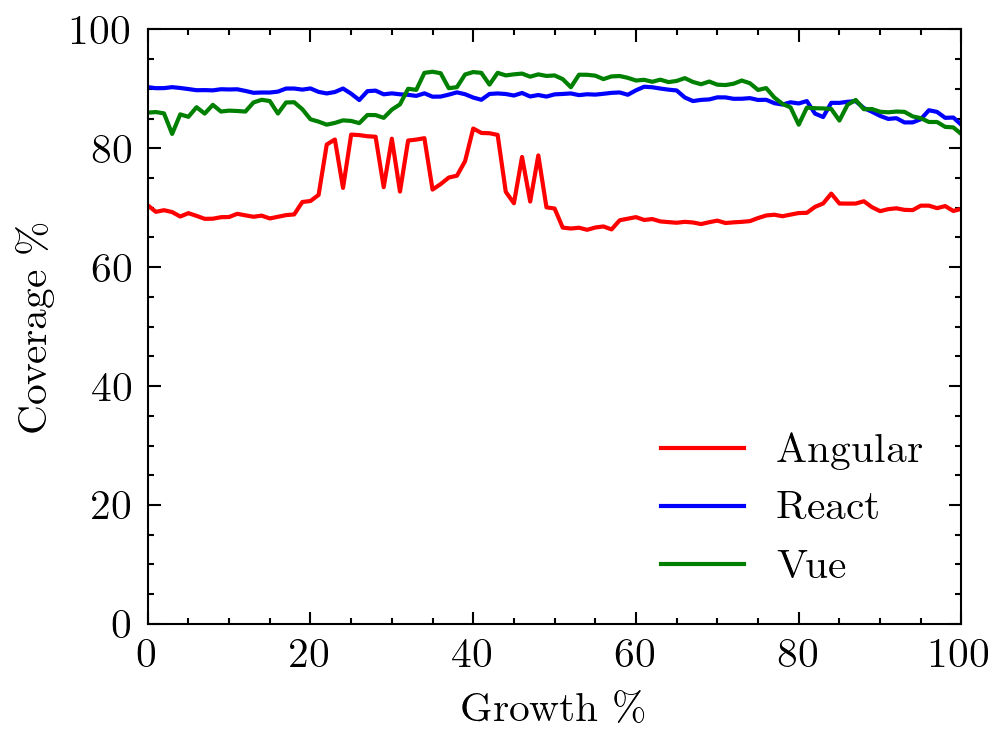

In [8]:
fig, ax = plt.subplots(dpi=300)


for wf, color in zip(WEBFRAMEWORKS, COLORS):
    points = []

    for repo in repos:
        
        if get_webframework(repo) != wf:
            continue
            
        reports = repo.codecov_reports
        metrics = [get_metrics(report) for report in reports]

        coverage = [m['coverage'] for m in metrics if 'coverage' in m]
        completion = np.linspace(0, 100, len(coverage))

        for cov, com in zip(coverage, completion):
            points.append((round(com), cov))
      
    x = list(range(101))
    y = []
    yerr = []
    for com in x:
        coverages = [i[1] for i in points if i[0] == com]
        coverages = reject_outliers(coverages)
        y.append(np.mean(coverages))
        yerr.append(np.std(coverages))

    ax.plot(x, y, color=color, label=wf)
        
        
ax.set_xlabel('Growth \%')
ax.set_ylabel('Coverage \%')
ax.legend(loc='lower right')
ax.set_xlim([0, 100])
ax.set_ylim([0, 100])
fig.show()
fig.savefig('../plots/growth-rq3-coverage.pdf', transparent = True, bbox_inches = 'tight', dpi=300)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


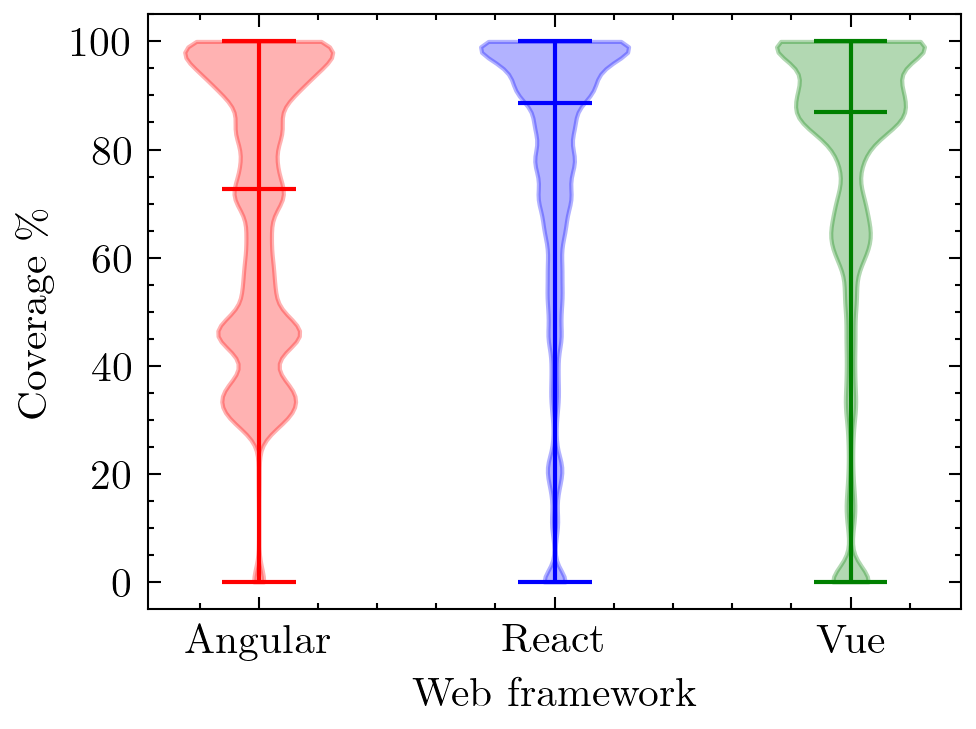

In [9]:
fig, ax = plt.subplots(dpi=300)

for wf, color in zip(WEBFRAMEWORKS, COLORS):

    dist = []
    for repo in repos:
        
        if get_webframework(repo) != wf:
            continue
            
        reports = repo.codecov_reports
        metrics = [get_metrics(report) for report in reports]

        coverage = [m['coverage'] for m in metrics if 'coverage' in m]
        dist.extend(coverage)
    
    parts = ax.violinplot([dist], positions=[WEBFRAMEWORKS.index(wf)], showmedians=True)
    parts['bodies'][0].set_facecolor(color)
    parts['bodies'][0].set_edgecolor(color)
    for partname in ('cbars','cmins','cmaxes','cmeans','cmedians'):
        if partname in parts:
            vp = parts[partname]
            vp.set_edgecolor(color)
            vp.set_linewidth(1)
                
        
ax.set_xlabel('Web framework')
ax.set_ylabel('Coverage \%')
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(WEBFRAMEWORKS)
ax.legend()
fig.show()
fig.savefig('../plots/dist-rq3-coverage.pdf', transparent = True, bbox_inches = 'tight', dpi=300)